In [1]:
import os
import pickle
import random

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# Set the city name or coordinates for Gurgaon
place_name = "Gurgaon, India"

# Download the street network
gurugram_graph = ox.graph_from_place(place_name, network_type="all_private")

In [2]:
study_area = gpd.read_file('geodata/study_area.csv')

# Project the GeoDataFrame to the same CRS as the graph
study_area = study_area.set_crs(gurugram_graph.graph['crs'])

In [3]:
dense_area = gpd.read_file('geodata/dense_area.csv')
dense_area = dense_area.set_crs(gurugram_graph.graph['crs'])
sparse_area = gpd.read_file('geodata/sparse_area.csv')
sparse_area = sparse_area.set_crs(gurugram_graph.graph['crs'])
dark_stores = gpd.read_file('geodata/blinkit_stores.csv')
display(dark_stores)

,WKT,name,description,geometry
0,POINT (77.094912 28.462015 0.0),blinkit,,POINT Z (77.09491 28.46202 0.00000)
1,POINT (77.04601 28.427039 0.0),Blinkit sector 47,,POINT Z (77.04601 28.42704 0.00000)
2,POINT (77.041041 28.461018 0.0),Blinkit online store,,POINT Z (77.04104 28.46102 0.00000)
3,POINT (77.086489 28.472832 0.0),Blinkit store,,POINT Z (77.08649 28.47283 0.00000)
4,POINT (77.072826 28.413124 0.0),Blinkit Store (Online) Sector 50,,POINT Z (77.07283 28.41312 0.00000)
5,POINT (77.056567 28.390908 0.0),BlinkIt Store(Dark Store),,POINT Z (77.05657 28.39091 0.00000)
6,POINT (77.073085 28.441506 0.0),Blinkit warehouse,,POINT Z (77.07309 28.44151 0.00000)
7,POINT (77.045226 28.402609 0.0),Blinkit Dark Store,,POINT Z (77.04523 28.40261 0.00000)
8,POINT (77.059314 28.406399 0.0),Blinkit Dark Store,,POINT Z (77.05931 28.40640 0.00000)
9,POINT (77.035943 28.417696 0.0),Blinkit store sector 48,,POINT Z (77.03594 28.41770 0.00000)


In [4]:
# Create sub-graphs
study_area_graph = ox.graph_from_polygon(study_area.geometry[0], network_type='all_private', retain_all=True)
dense_area_graph = ox.graph_from_polygon(dense_area.geometry[0], network_type='all_private', retain_all=True)
sparse_area_graph = ox.graph_from_polygon(sparse_area.geometry[0], network_type='all_private', retain_all=True)

In [5]:
dark_stores_focused = []

for idx, point in enumerate(dark_stores['geometry']):
    if point.within(dense_area.geometry.values[0]) or point.within(sparse_area.geometry.values[0]):
        dark_stores_focused.append(idx)
        
dark_stores_focused = dark_stores.iloc[dark_stores_focused]

In [6]:
all_nodes = list(dense_area_graph.nodes) + list(sparse_area_graph.nodes)

#### Import all experiment data

In [7]:
# Specify the folder containing the pickle files
simulation_data_dir = "simulation_data"

# Load each list from its corresponding file
with open(os.path.join(simulation_data_dir, "delivery_iterations.pkl"), "rb") as f:
    delivery_iterations = pickle.load(f)

with open(os.path.join(simulation_data_dir, "dense_delivery_iterations.pkl"), "rb") as f:
    dense_delivery_iterations = pickle.load(f)

with open(os.path.join(simulation_data_dir, "sparse_delivery_iterations.pkl"), "rb") as f:
    sparse_delivery_iterations = pickle.load(f)

with open(os.path.join(simulation_data_dir, "simulation_data.pkl"), "rb") as f:
    simulation_data = pickle.load(f)

In [8]:
num_simulations = len(simulation_data)

In [9]:
# Check the shape of our simulation data for the dense zone
temp = pd.DataFrame(dense_delivery_iterations)
display(temp.shape)
del temp

(5, 15)

In [10]:
# get the number of delivery points and executives (per zone)
num_delivery_points = pd.DataFrame(dense_delivery_iterations).shape[1]
num_delivery_executives = num_delivery_points // 5

#### Visualize the network on the map

/var/folders/lt/njk9c7vd43n4xfmcy1kt75c40000gn/T/ipykernel_71217/304383436.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(['Service Areas', 'Dense Customers', 'Sparse Customers', 'Dark Stores'])


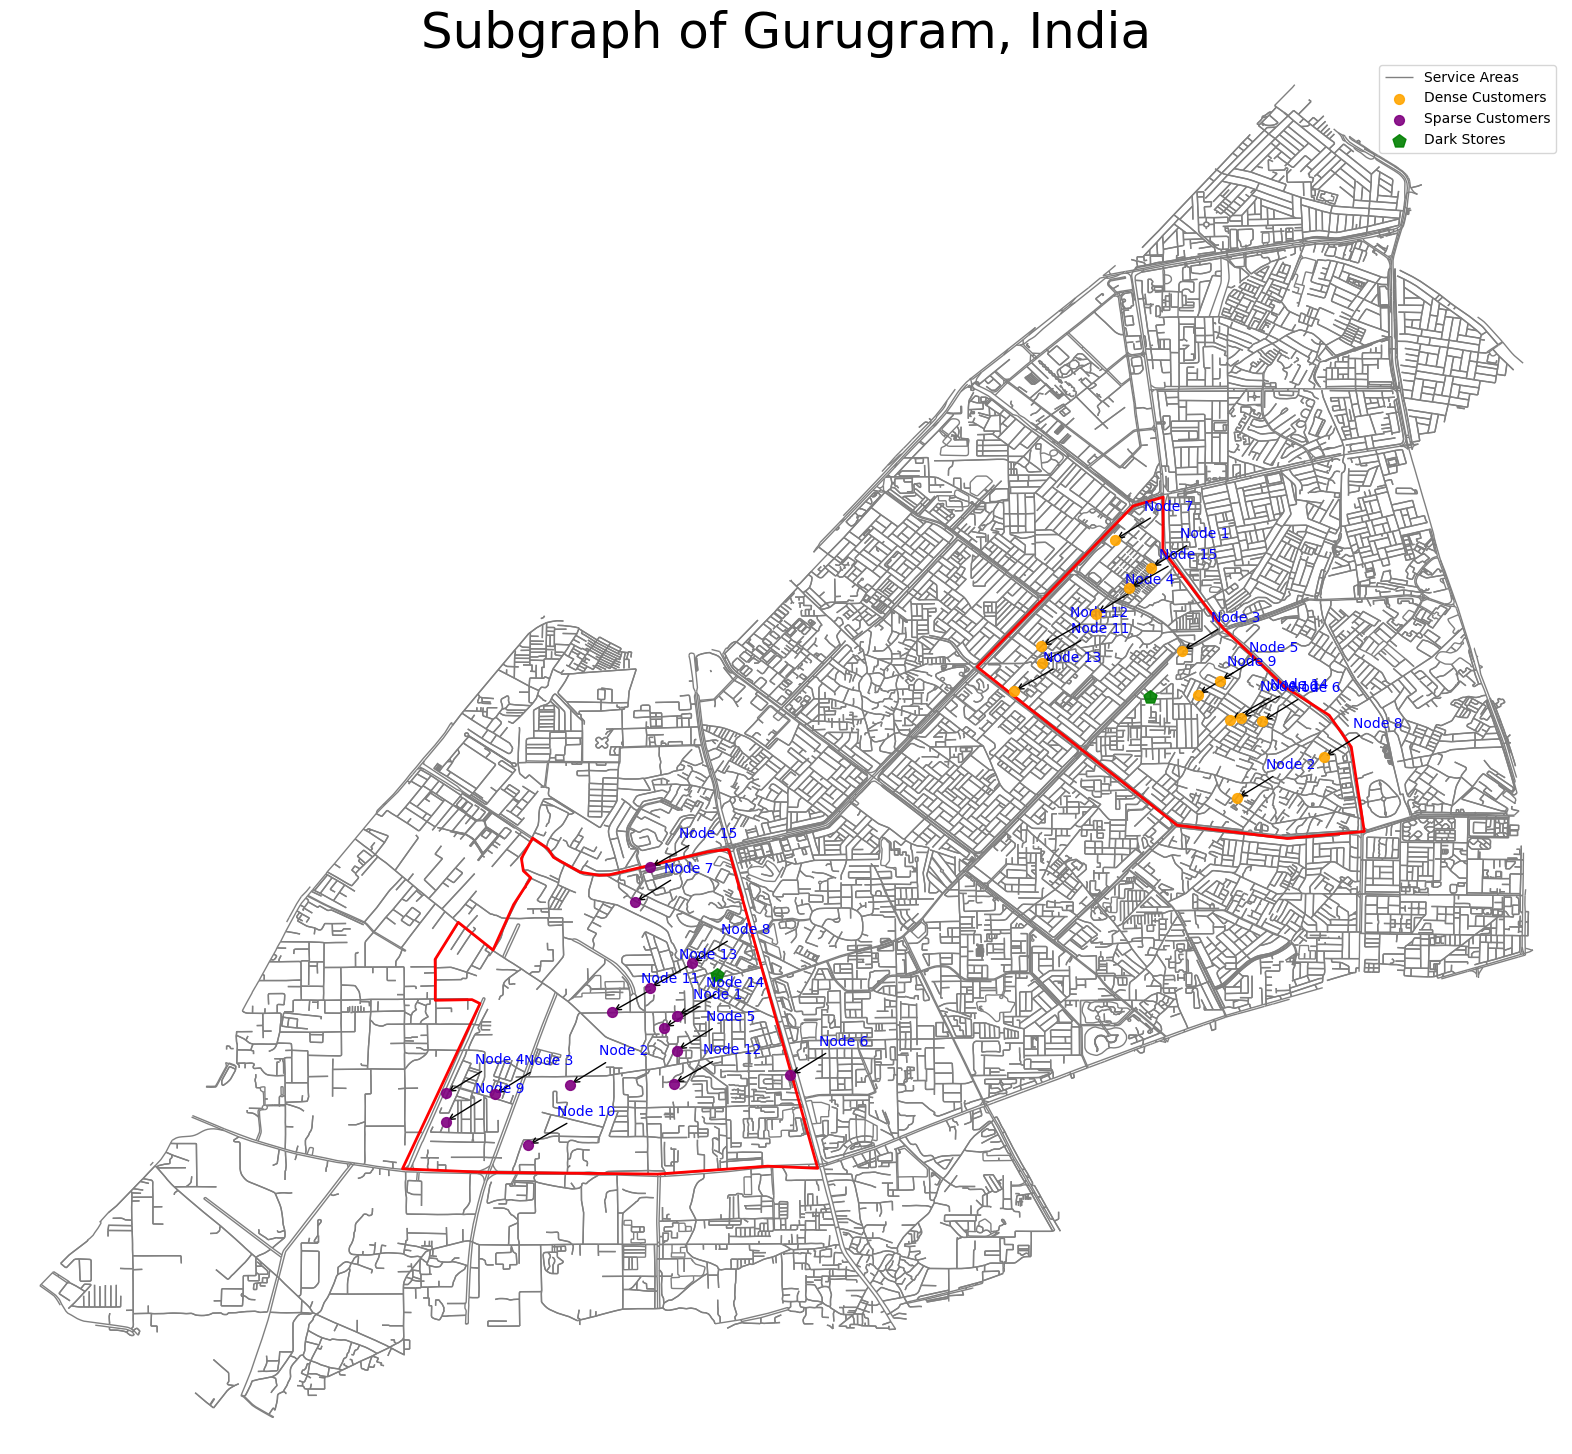

In [11]:
figsize = (32, 18)

fig, ax = ox.plot_graph(study_area_graph, node_size=0, edge_color="gray", bgcolor="white", show=False, figsize=figsize)

ax.scatter(np.array(dense_delivery_iterations[0])[:, 0], np.array(dense_delivery_iterations[0])[:, 1], c="orange", s=50, zorder=4, alpha=0.9, label=range(num_delivery_points))
ax.scatter(np.array(sparse_delivery_iterations[0])[:, 0], np.array(sparse_delivery_iterations[0])[:, 1], c="purple", s=50, zorder=4, alpha=0.9)

offset = 0.0025

#Use the annotate() function to annotate each data point with arrows in the scatter plot
for i in range(num_delivery_points) :
    ax.annotate(f'Node {i+1}', (np.array(dense_delivery_iterations[0])[:, 0][i], np.array(dense_delivery_iterations[0])[:, 1][i]), xytext=(
    np.array(dense_delivery_iterations[0])[:, 0][i] + offset, np.array(dense_delivery_iterations[0])[:, 1][i] + offset), arrowprops=dict(arrowstyle='->'), color='blue')
    ax.annotate(f'Node {i+1}', (np.array(sparse_delivery_iterations[0])[:, 0][i], np.array(sparse_delivery_iterations[0])[:, 1][i]), xytext=(
    np.array(sparse_delivery_iterations[0])[:, 0][i] + offset, np.array(sparse_delivery_iterations[0])[:, 1][i] + offset), arrowprops=dict(arrowstyle='->'), color='blue')

dense_area.plot(ax=ax, color="none", edgecolor="red", linewidth=2, label='Study Area')
sparse_area.plot(ax=ax, color="none", edgecolor="red", linewidth=2)
dark_stores_focused.plot(ax=ax, color="green", marker='p', markersize=96, alpha=0.9)
ax.set_title("Subgraph of Gurugram, India", fontsize=36)

plt.legend(['Service Areas', 'Dense Customers', 'Sparse Customers', 'Dark Stores'])
plt.show()

## Simulate Performance with Benchmark Model

#### Define method for running and reporting the simulation

In [12]:
# This variable will be used to upscale the elapsed time between nodes 
# This is nevessary because the routing solver works over the integers.
# Many of our values are less than 1, thus they will lose a great amount of fidelity
time_scale_factor = 1000

In [13]:
def get_solution(data, manager, routing, solution):
    current_time_matrix = data['derived_time_matrix']
    current_distance_matrix = data['distance_matrix']
    
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue() / time_scale_factor}")
    max_wait_time = 0
    
    total_driving_time = 0
    total_distance = 0
    total_emissions = 0
    total_fuel_cost = 0
    total_monetary_cost = 0
    
    # TODO: Change the number of vehicles used in this model. By default, the number is set to 'num_delivery_points // 5'
    # data["num_vehicles"] = <insert_here> 

    for route_id in range(data["num_vehicles"]):
        index = routing.Start(route_id)
        plan_output = f"Route for vehicle {route_id}:\n"
        
        route_time = 0
        route_distance = 0
        route_emissions = 0
        route_fuel_cost = 0
        route_monetary_cost = 0
        
        # Route to the next link
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))

            # link_time = routing.GetArcCostForVehicle(
            #     previous_index, index, vehicle_id
            # )
            
            # TODO: Accounted for the `time_scale_factor`
            link_time = current_time_matrix[manager.IndexToNode(previous_index)][manager.IndexToNode(index)] / 1000
            link_distance = current_distance_matrix[manager.IndexToNode(previous_index)][manager.IndexToNode(index)]
            link_emissions = get_link_emissions(link_time)
            link_fuel_cost = get_link_fuel_cost(link_time)
            link_monetary_cost = get_link_monetary_cost(link_time)

            route_time += link_time
            route_distance += link_distance
            route_emissions += link_emissions
            route_fuel_cost += link_fuel_cost
            route_monetary_cost += link_monetary_cost
            
            print(f"Travel time between Node {manager.IndexToNode(previous_index)} and Node {manager.IndexToNode(index)}: {link_time} min")


        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Time elapsed on route: {route_time} min\n"
        plan_output += f"Distance travelled on route: {route_distance} km\n"
        plan_output += f"Emissions of the route: {route_emissions:.4} kg CO2\n"
        plan_output += f"Fuel cost of the route: ${route_monetary_cost:.4}"
        print(plan_output)
        print()

        max_wait_time = max(route_time, max_wait_time)
        
        total_driving_time += route_time
        total_distance += route_distance
        total_emissions += route_emissions
        total_fuel_cost += route_fuel_cost
        total_monetary_cost += route_monetary_cost
        
        
    print("----------------------------------------")
    print(f"Maximum time spent on a delivery run: {max_wait_time} min")
    print()
    print(f"Total time spent on road by all delivery executives: {total_driving_time}")
    print(f"Total emissions from operations: {total_emissions} kg CO2")
    print(f"Total cost of operations: ${total_monetary_cost:.3}")
    
    return [max_wait_time, total_distance, total_emissions, total_fuel_cost, total_monetary_cost]


In [14]:
simulation_managers = []
simulation_routing = []

for data in simulation_data:
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["derived_time_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    simulation_managers.append(manager)
    simulation_routing.append(routing)

In [24]:
pd.DataFrame(simulation_data[0]['distance_matrix'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000,2.400,1.686,1.391,1.556,1.349,1.800,2.718,2.953,0.512,1.364,1.615,1.495,2.451,1.485,1.778
1,1.852,0.000,4.017,2.060,0.989,2.527,2.764,0.807,3.547,2.333,2.824,1.998,1.591,2.722,2.704,0.269
2,1.686,3.393,0.000,2.744,3.759,2.610,1.595,4.123,1.549,1.393,1.159,3.105,2.985,3.675,1.280,3.500
3,0.746,1.582,2.910,0.000,1.218,2.064,3.360,1.900,4.841,1.227,2.924,2.040,1.920,2.876,3.045,0.960
4,1.862,0.879,3.538,1.419,0.000,3.180,3.566,1.155,4.349,2.343,3.551,1.110,0.703,2.207,3.505,0.516
5,1.745,2.317,3.018,1.668,2.682,0.000,1.799,3.046,2.582,1.245,1.859,3.710,3.591,4.415,1.738,2.424
6,2.274,2.174,1.595,1.525,2.539,1.391,0.000,2.903,1.989,0.819,0.436,3.568,3.448,4.272,0.288,2.281
7,2.484,0.731,4.648,2.040,1.118,3.180,3.417,0.000,4.200,2.964,3.478,1.915,1.705,2.141,3.357,1.138
8,3.063,2.963,1.549,2.315,3.329,2.180,1.961,3.693,0.000,2.447,2.021,4.357,4.237,5.062,1.900,3.071
9,0.534,2.210,1.405,1.561,2.059,0.871,0.819,2.939,2.475,0.000,1.025,2.117,1.998,2.954,1.146,2.281


#### Define helper methods

In [15]:
# TODO: Change the assumed average speed to something relevant to the benchmark model 
assumed_average_speed = 40 #km/h

In [16]:
def get_link_emissions(time, coef=1.0):
    distance = assumed_average_speed * time / 60
    print(f'Distance travelled: {distance:.10} km')
    kg_co2_per_km = 0.11337 * coef
    return distance * kg_co2_per_km

def get_link_fuel_cost(time, coef=1.0):
    distance = assumed_average_speed * time / 60
    fuel_consumption_rate_per_km = 0.0166 * coef

    return distance * fuel_consumption_rate_per_km

def get_link_monetary_cost(time, coef=1.0):
    distance = assumed_average_speed * time / 60
    fuel_consumption_rate_per_km = 0.0166 * coef
    dollar_price_per_liter = 1.17
    
    return distance * fuel_consumption_rate_per_km * dollar_price_per_liter


#### Define callbacks
These callbacks help the model track the effects of a delivery executive moving between nodes.

The elapsed time callback is supposed to be used to track the amount of time accumulated by each executive.

The callback will later be passed to the AddDimension() function, which defines the constraint.

We should be able to make new constraints by adding more dimensions and creating the callbacks that accurately affect the system.

In [17]:
# Define callback to add elapsed time to route
def transit_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to time matrix NodeIndex.
    
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    
    elapsed_time = data['derived_time_matrix'][from_node][to_node]
    
    # print(f"Requesting elapsed time between Node {from_index} and Node {to_index}: {elapsed_time}")
    
    return elapsed_time

In [18]:
benchmark_system_simulation_results = pd.DataFrame(index=range(num_simulations), columns=['Maximum Wait Time for Order', 'Total Distance for all Orders', 'Total Emissions Produced', 'Total Fuel Burned', 'Total Monetary Cost'])

for i in range(num_simulations):
    data = simulation_data[i]
    routing = simulation_routing[i]
    manager = simulation_managers[i]
    
    # Upscale the time_matrix
    data['derived_time_matrix'] = (np.array(simulation_data[i]['derived_time_matrix']) * time_scale_factor).tolist()
    
    # Register the elapsed time callback for a delivery executive travelling between two nodes
    transit_callback_index = routing.RegisterTransitCallback(transit_callback)
    
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add time constraint to the VRP
    # Routing programs use dimensions to keep track of quantities that accumulate over a vehicle's route.    
    dimension_name = "Time"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        42 * time_scale_factor,  # maximum route time - 42 minutes the maximum time customers are willing to wait for an order
        True,  # start cumul to zero
        dimension_name,
    )
    time_dimension = routing.GetDimensionOrDie(dimension_name)
    time_dimension.SetGlobalSpanCostCoefficient(100)
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    
    # Set the heuristic to Clarke-Wright Savings Method
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.SAVINGS
    )
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    
    # Print solution on console.
    if solution:
        benchmark_system_simulation_results.iloc[i] = get_solution(data, manager, routing, solution)
    else:
        print("No solution found !")
    

Objective: 1116.223
Distance travelled: 1.364 km
Travel time between Node 0 and Node 10: 2.0460000000000003 min
Distance travelled: 0.192 km
Travel time between Node 10 and Node 14: 0.28800000000000003 min
Distance travelled: 0.288 km
Travel time between Node 14 and Node 6: 0.432 min
Distance travelled: 2.903 km
Travel time between Node 6 and Node 7: 4.3545 min
Distance travelled: 2.484 km
Travel time between Node 7 and Node 0: 3.726 min
Route for vehicle 0:
 0 ->  10 ->  14 ->  6 ->  7 -> 0
Time elapsed on route: 10.846499999999999 min
Distance travelled on route: 7.231 km
Emissions of the route: 0.8198 kg CO2
Fuel cost of the route: $0.1404

Distance travelled: 1.686 km
Travel time between Node 0 and Node 2: 2.529 min
Distance travelled: 1.549 km
Travel time between Node 2 and Node 8: 2.3234999999999997 min
Distance travelled: 2.18 km
Travel time between Node 8 and Node 5: 3.2700000000000005 min
Distance travelled: 1.245 km
Travel time between Node 5 and Node 9: 1.8675000000000002 mi

In [19]:
display(benchmark_system_simulation_results)

,Maximum Wait Time for Order,Total Distance for all Orders,Total Emissions Produced,Total Fuel Burned,Total Monetary Cost
0,10.8465,21.085,2.390406,0.350011,0.409513
1,10.086,19.511,2.211962,0.323883,0.378943
2,9.978,17.578,1.992818,0.291795,0.3414
3,9.435,16.189,1.835347,0.268737,0.314423
4,8.007,14.928,1.692387,0.247805,0.289932


In [20]:
averages = pd.DataFrame(benchmark_system_simulation_results.mean()).T
averages.columns = columns=['Avg. Maximum Wait Time for Order', 'Avg. Distance for all Orders', 'Avg. Emissions Produced', 'Avg. Fuel Burned', 'Avg. Monetary Cost']
averages

averages.to_csv('proposed_model_performance.csv')